# KERAS and TENSORFLOW-THEANO
TUTORIAL: Derive a regression to correct the pT of the Leading and SubLeading b-jets  
(%lsmagic for magic commanda and ! for bash instruction)

In [32]:
# We start by importing all the necessary packages
import sys;
import os, sys, array, re, math, random, subprocess, glob
from math import *
import numpy as np
import scipy
from numpy.lib.recfunctions import stack_arrays
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cPickle
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils import compute_class_weight
from sklearn.model_selection import KFold
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Highway, MaxoutDense, Masking, GRU, Merge, Input, merge
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor
import deepdish.io as io
import ROOT
from ROOT import gSystem, gROOT, gApplication, TFile, TTree, TCut, TH1F, TCanvas
from root_numpy import root2array 
from IPython.display import HTML, IFrame
import seaborn as sns; sns.set()
print "I you had no error so far, this is great! We can start the tutorial."

I you had no error so far, this is great! We can start the tutorial.


We set some variables we will use later

In [33]:
# Check this file out, it contains many functions we will use.
execfile("Useful_func.py")
# Fix random seed for reproducibility
seed = 7; np.random.seed(seed);
# Input paramters
doSubLead = False # Choose if to do regression on Leading or Subleading Jets
debug = True #(Verbose output)
folder='Plots_Regression/' # Folder with Plots
MakePlots=True # Set False if you want to run faster
folderCreation  = subprocess.Popen(['mkdir -p ' + folder], stdout=subprocess.PIPE, shell=True); folderCreation.communicate()
folderCreation2 = subprocess.Popen(['mkdir -p models/'], stdout=subprocess.PIPE, shell=True); folderCreation2.communicate()

('', None)

Now We Start manipulating ROOT files into a format we can use to train a MVA

In [34]:
# Our goal is to correct the Leading and SubLeading jet pT so that the value is closer to the b-parton pT. We can do that:
# 1) Applying a preselection to out Signal and background events
my_selec_jet1 = 'b1genjet_pt>20 && met_pt>20 && met_pt<500 && muon1_pt>20 && fabs(muon1_eta)<2.4 && pt_l1l2<500 && pt_b1b2<500 && mass_l1l2>12 && mass_l1l2<500 && mass_b1b2<500 && b1jet_pt>30 && fabs(b1jet_eta)<2.4 && b2jet_pt>30 && fabs(b2jet_eta)<2.4 && mass_trans>10 && mass_trans<500 && HT<4000'
my_selec_jet2 = 'b2genjet_pt>15 && met_pt>20 && met_pt<500 && muon2_pt>10 && fabs(muon2_eta)<2.4 && pt_l1l2<500 && pt_b1b2<500 && mass_l1l2>12 && mass_l1l2<500 && mass_b1b2<500 && b1jet_pt>25 && fabs(b1jet_eta)<2.4 && b2jet_pt>25 && fabs(b2jet_eta)<2.4 && mass_trans>10 && mass_trans<500 && HT<4000'
# 2) Selecting the branches that contains the information we want to use (in general)
my_branches_jet1 = ['b1jet_pt','b1jet_eta','b1genjet_pt']#["numOfVertices","b1jet_pt","b1jet_eta","b1jet_mt","b1jet_leadTrackPt","b1jet_leptonDeltaR","b1jet_leptonPtRel","b1jet_leptonPt","b1jet_vtxPt","b1jet_vtxMass","b1jet_vtxNtracks","b1jet_neHEF","b1jet_neEmEF","b1jet_vtx3DSig","b1jet_vtx3DVal","b1genjet_pt"]
my_branches_jet2 = ['b2jet_pt','b2jet_eta','b2genjet_pt']#["numOfVertices","b2jet_pt","b2jet_eta","b2jet_mt","b2jet_leadTrackPt","b2jet_leptonDeltaR","b2jet_leptonPtRel","b2jet_leptonPt","b2jet_vtxPt","b2jet_vtxMass","b2jet_vtxNtracks","b2jet_neHEF","b2jet_neEmEF","b2jet_vtx3DSig","b2jet_vtx3DVal","b2genjet_pt"]
# 3) Selecting the branches that contains the information we want to use (in the training)
my_branches_training_jet1 = ['b1jet_pt','b1jet_eta']#["numOfVertices","b1jet_pt","b1jet_eta","b1jet_mt","b1jet_leadTrackPt","b1jet_leptonDeltaR","b1jet_leptonPtRel","b1jet_leptonPt","b1jet_vtxPt","b1jet_vtxMass","b1jet_vtxNtracks","b1jet_neHEF","b1jet_neEmEF","b1jet_vtx3DSig","b1jet_vtx3DVal"]
my_branches_training_jet2 = ['b2jet_pt','b2jet_eta']#["numOfVertices","b2jet_pt","b2jet_eta","b2jet_mt","b2jet_leadTrackPt","b2jet_leptonDeltaR","b2jet_leptonPtRel","b2jet_leptonPt","b2jet_vtxPt","b2jet_vtxMass","b2jet_vtxNtracks","b2jet_neHEF","b2jet_neEmEF","b2jet_vtx3DSig","b2jet_vtx3DVal"]
# Converting Root files in dataframe (Very useful, checnl root2panda in Useful_func.py)
LeadJet    = root2panda('files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-500_narrow_13TeV-madgraph-v2.root', 'DiHiggsWWBBAna/evtree', branches=my_branches_jet1, selection=my_selec_jet1)
SubLeadJet = root2panda('files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-500_narrow_13TeV-madgraph-v2.root', 'DiHiggsWWBBAna/evtree', branches=my_branches_jet2, selection=my_selec_jet2)
# Define the target of the regression. It is the weight we would like to apply to the RECO pT.
LeadJet["target"] = LeadJet["b1genjet_pt"]/LeadJet["b1jet_pt"]
SubLeadJet["target"] = SubLeadJet["b2genjet_pt"]/SubLeadJet["b2jet_pt"]

if debug:
  print("---> hh Displayed as panda dataframe: "); print(LeadJet)
  print("The shape for LeadJet is (samples, features): "); print(LeadJet.shape)
  print("The shape for SubLeadJet is (samples, features): "); print(SubLeadJet.shape)

---> hh Displayed as panda dataframe: 
        b1jet_pt  b1jet_eta  b1genjet_pt    target
0     173.124298  -0.714916   172.178650  0.994538
1     246.682297   0.298446   195.914536  0.794198
2     340.403229   1.258016   304.522736  0.894594
3      80.552818   2.200674    54.073444  0.671279
4      86.618324  -1.492352    81.036469  0.935558
5     147.646530   0.765988   160.419449  1.086510
6     179.774414  -0.576904   190.524002  1.059795
7     160.337036  -0.464420   145.027847  0.904519
8      67.824074   1.615699    40.859528  0.602434
9     118.275604  -1.762509    29.835064  0.252250
10    174.260849   1.073892    25.439190  0.145983
11    142.049393   2.365291    54.086449  0.380758
12    124.097084  -1.880355   148.629974  1.197691
13    143.997528   0.601616   142.146790  0.987147
14    168.491440  -0.539859    38.814510  0.230365
15     73.634766   0.321159    75.007530  1.018643
16    119.909294  -1.196250   112.457726  0.937857
17     61.311272   1.524936   103.063805  1

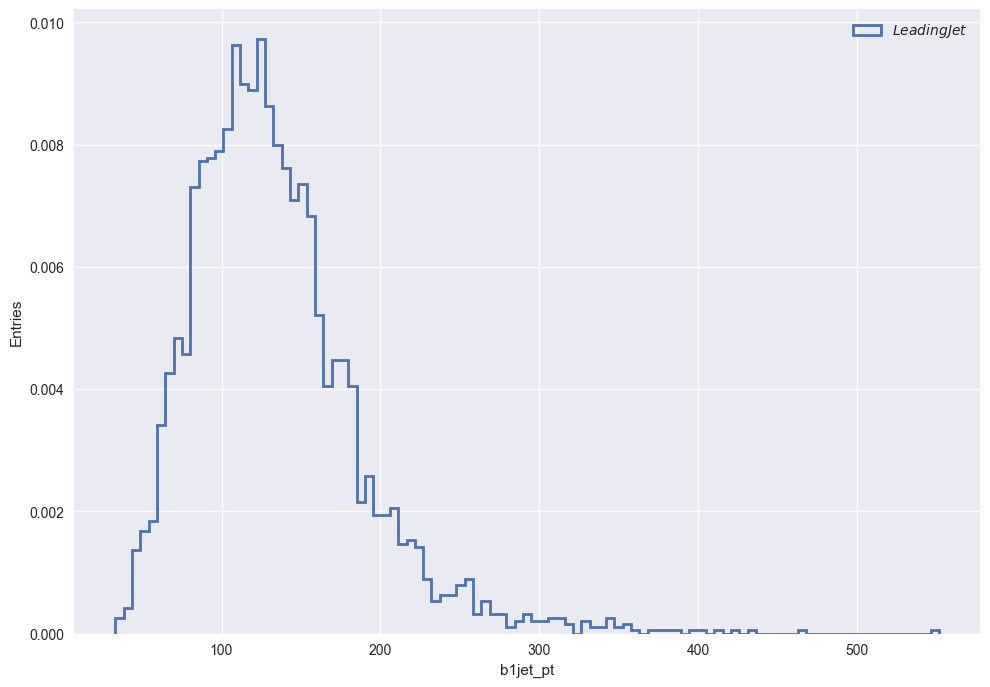

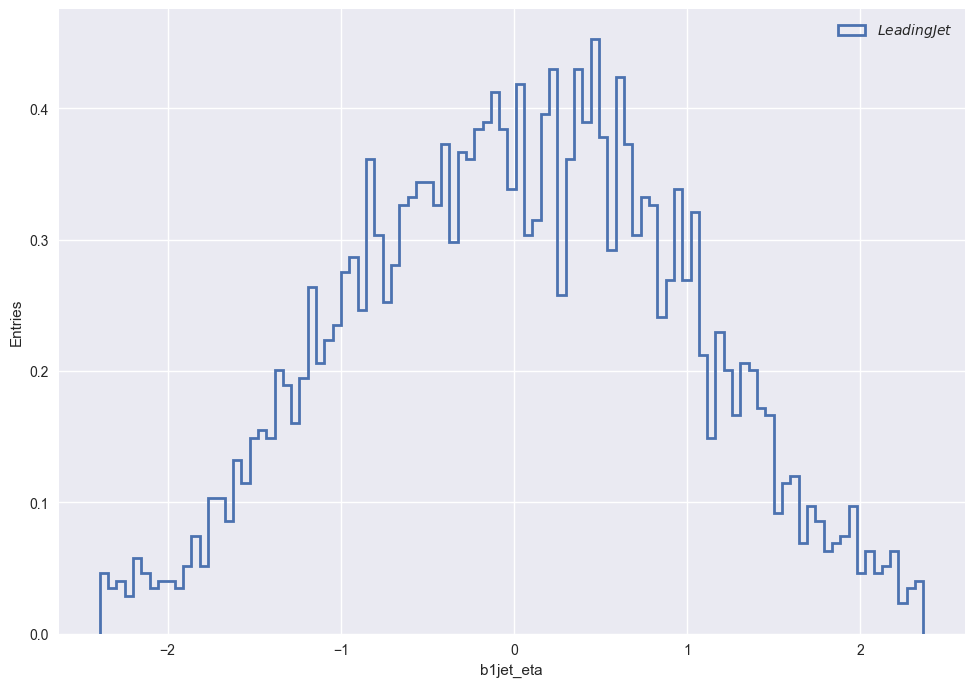

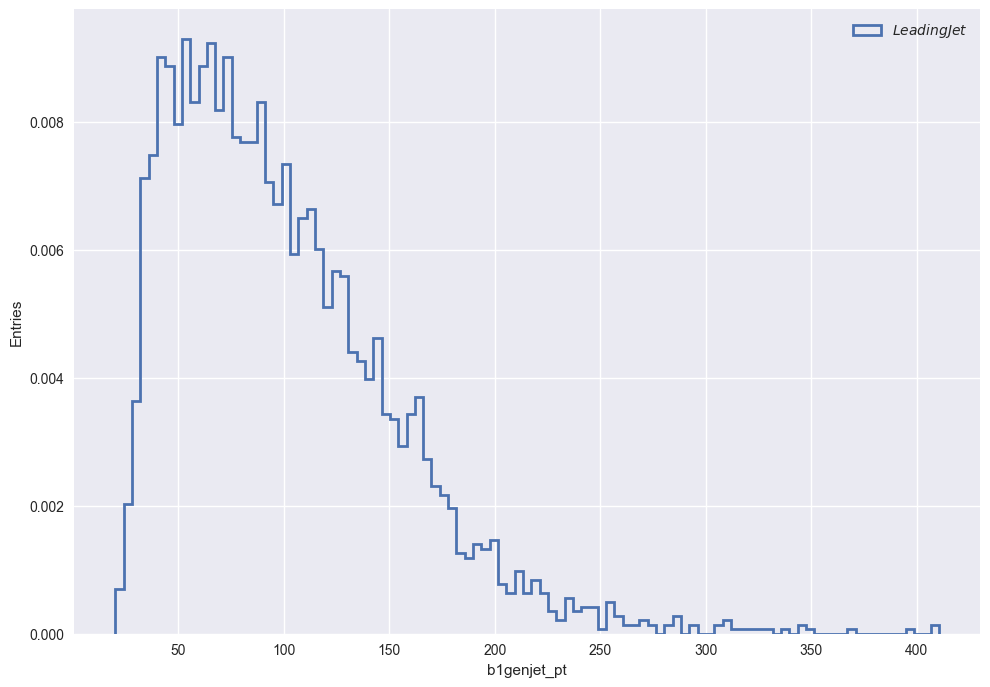

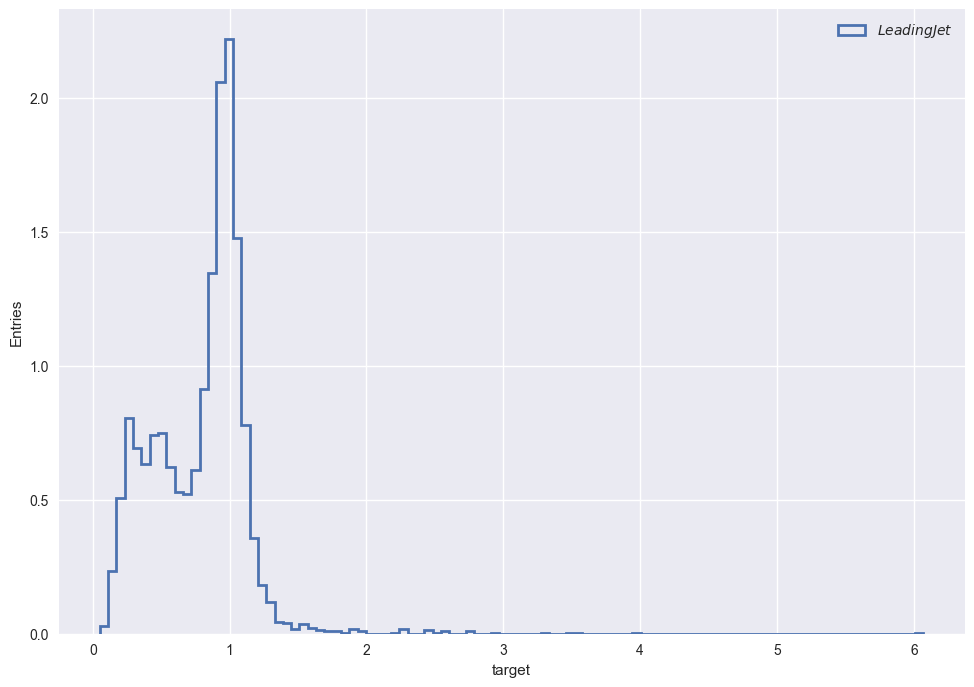

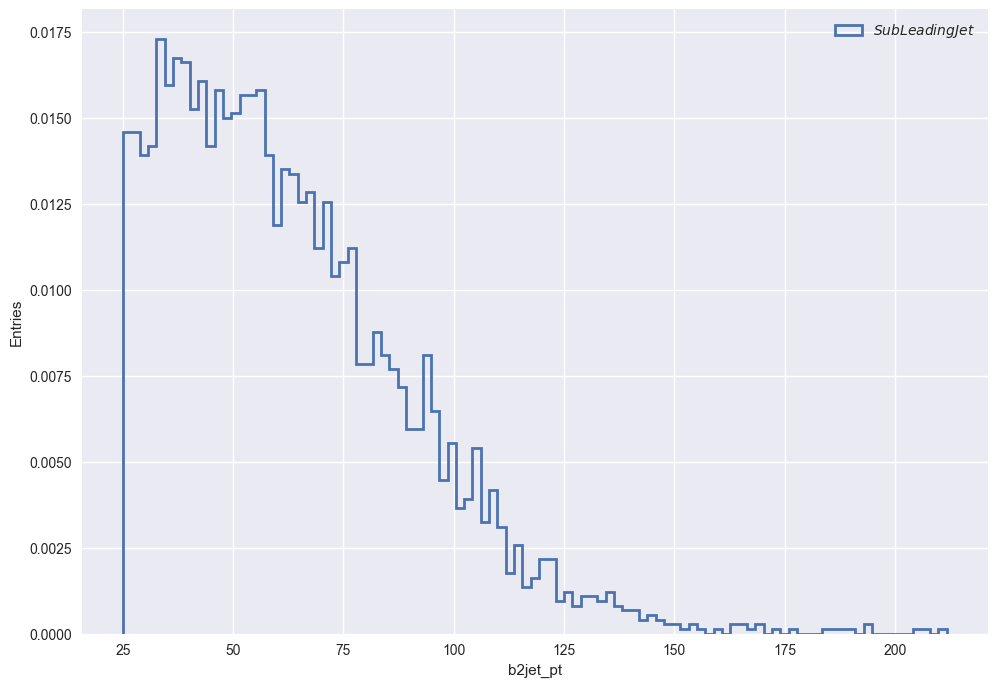

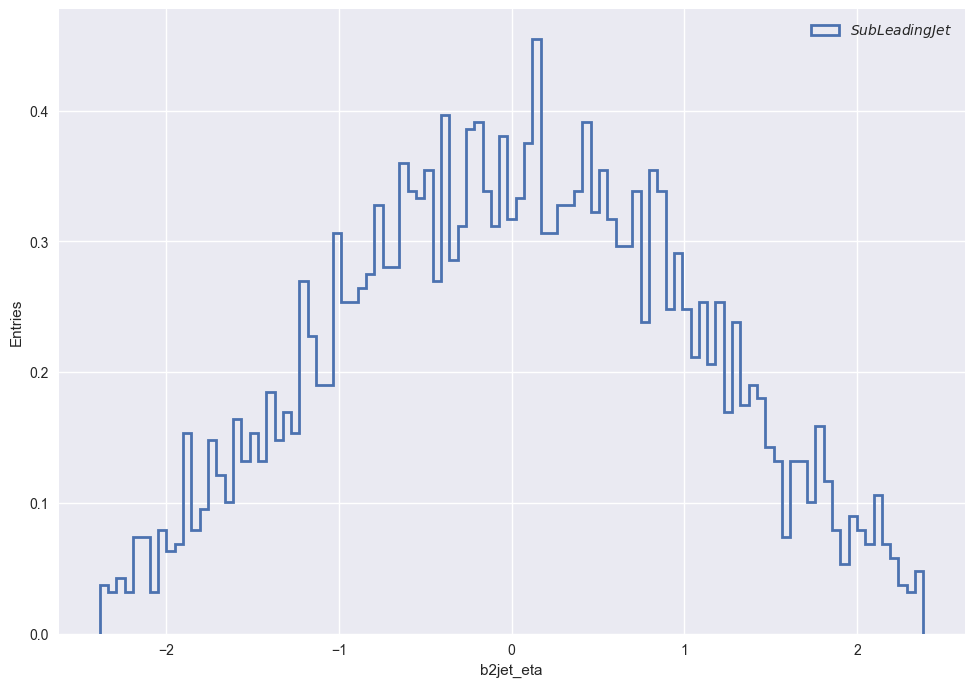

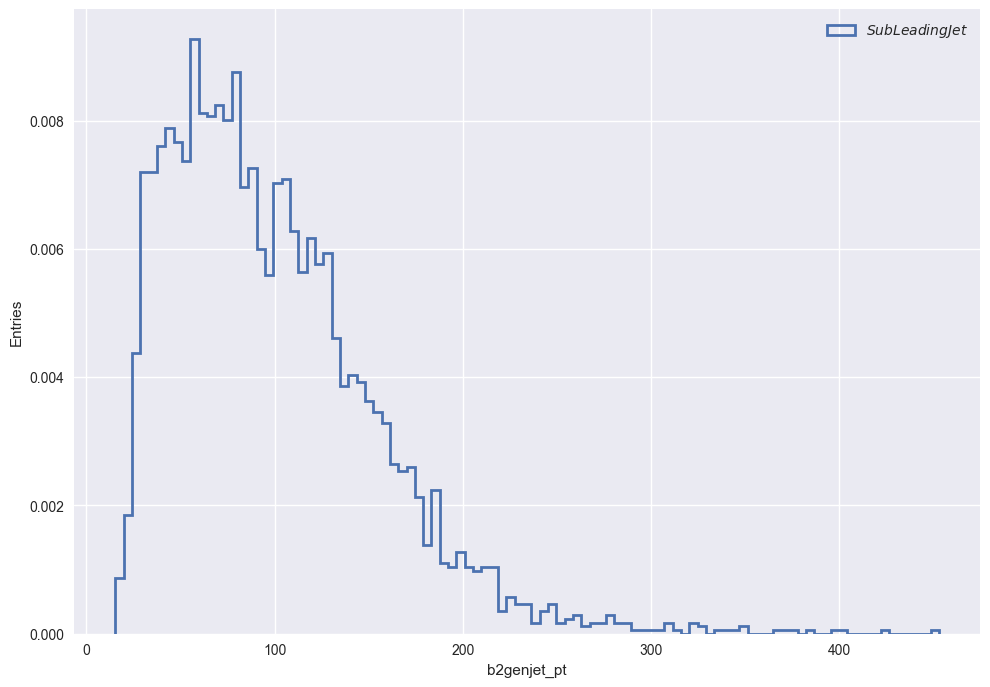

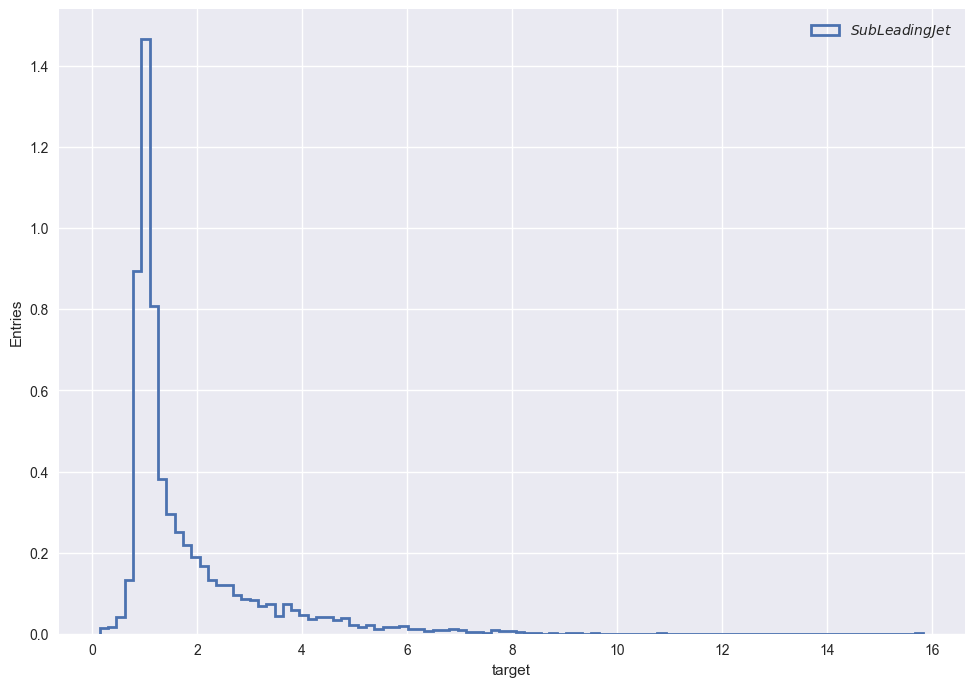

('Saving:', 'Plots_Regression//Lead_jet_b1jet_pt.pdf')
('Saving:', 'Plots_Regression//Lead_jet_b1jet_eta.pdf')
('Saving:', 'Plots_Regression//Lead_jet_b1genjet_pt.pdf')
('Saving:', 'Plots_Regression//Lead_jet_target.pdf')
('Saving:', 'Plots_Regression//SubLead_jet_b2jet_pt.pdf')
('Saving:', 'Plots_Regression//SubLead_jet_b2jet_eta.pdf')
('Saving:', 'Plots_Regression//SubLead_jet_b2genjet_pt.pdf')
('Saving:', 'Plots_Regression//SubLead_jet_target.pdf')


In [35]:
%matplotlib inline
# Plots of the branches we selected
if MakePlots:
  for key in LeadJet.keys() :
    matplotlib.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
    bins = np.linspace(my_max(min(LeadJet[key]),-99.), max(LeadJet[key]), 100)
    _ = plt.hist(LeadJet[key],  bins=bins, histtype='step', normed=True, label=r'$Leading Jet$', linewidth=2)
    plt.xlabel(key)
    plt.ylabel('Entries')
    plt.legend(loc='best')
    print('Saving:',folder + '/Lead_jet_' + str(key) + '.pdf')
    plt.savefig(folder + "/Lead_jet_" + str(key) + '.pdf')
  for key in SubLeadJet.keys() :
    matplotlib.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
    bins = np.linspace(my_max(min(SubLeadJet[key]),-99.), max(SubLeadJet[key]), 100)
    _ = plt.hist(SubLeadJet[key],  bins=bins, histtype='step', normed=True, label=r'$SubLeading Jet$', linewidth=2)
    plt.xlabel(key)
    plt.ylabel('Entries')
    plt.legend(loc='best')
    print('Saving:',folder + '/SubLead_jet_' + str(key) + '.pdf')
    plt.savefig(folder + "/SubLead_jet_" + str(key) + '.pdf')
        

In [36]:
# Lets look at the correlations of the features
c1 = ROOT.TCanvas(); c1.cd(); ROOT.gStyle.SetOptStat(0)
if MakePlots:
    h_Corr_Lead    = ROOT.TH2F("h_Corr_Lead","", len(my_branches_training_jet1), 0, len(my_branches_training_jet1), len(my_branches_training_jet1), 0, len(my_branches_training_jet1))
    h_Corr_SubLead = ROOT.TH2F("h_Corr_SubLead","", len(my_branches_training_jet2), 0, len(my_branches_training_jet2), len(my_branches_training_jet2), 0, len(my_branches_training_jet2))
    for var1 in range(len(my_branches_training_jet1)):
        h_Corr_Lead.GetXaxis().SetBinLabel(var1+1,my_branches_training_jet1[var1])
        h_Corr_SubLead.GetXaxis().SetBinLabel(var1+1,my_branches_training_jet2[var1])
        for var2 in range(len(my_branches_training_jet1)):
            h_Corr_Lead.GetYaxis().SetBinLabel(var2+1,my_branches_training_jet1[var2])
            h_Corr_SubLead.GetYaxis().SetBinLabel(var2+1,my_branches_training_jet2[var2])
            if(var2>=var1):
                array_Var1_Lead_var1    = np.array( LeadJet[my_branches_training_jet1[var1]] )
                array_Var1_Lead_var2    = np.array( LeadJet[my_branches_training_jet1[var2]] )
                array_Var1_SubLead_var1 = np.array( SubLeadJet[my_branches_training_jet2[var1]] )
                array_Var1_SubLead_var2 = np.array( SubLeadJet[my_branches_training_jet2[var2]] )
                corr = scipy.stats.pearsonr( array_Var1_Lead_var1, array_Var1_Lead_var2 )[0]
                h_Corr_Lead.SetBinContent(var1+1,var2+1,corr)
                corr = scipy.stats.pearsonr( array_Var1_SubLead_var1, array_Var1_SubLead_var2 )[0]
                h_Corr_SubLead.SetBinContent(var1+1,var2+1,corr)
    h_Corr_Lead.GetZaxis().SetRangeUser(-1.,1.)
    h_Corr_SubLead.GetZaxis().SetRangeUser(-1.,1.)
    ROOT.gStyle.SetPaintTextFormat(".2f");
    h_Corr_Lead.Draw("colzTEXT")
    c1.SaveAs(folder + '/Corr_Lead.pdf')
    h_Corr_SubLead.Draw("colzTEXT")
    c1.SaveAs(folder + '/Corr_SubLead.pdf')
    

Warning in <TROOT::Append>: Replacing existing TH1: h_Corr_Lead (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_Corr_SubLead (Potential memory leak).
Info in <TCanvas::Print>: pdf file Plots_Regression//Corr_Lead.pdf has been created
Info in <TCanvas::Print>: pdf file Plots_Regression//Corr_SubLead.pdf has been created


You need:
1. X : matrix with raw=#Events and column=Variables to discriminate."
2. w : A vector containig the weights of each event"
3. Y : A vector containing the target: genPt/recoPt. This is the weight you will then apply to the recoPt

In [37]:
print('Now lets start to talk about DNN!')
# Turn the df the desired ndarray "X" that can be directly used for ML applications.
X    = LeadJet[my_branches_training_jet1].as_matrix() # Each row is an object to classify, each column corresponds to a feature.
if (doSubLead):
    X = SubLeadJet[my_branches_training_jet2].as_matrix()
# No weights needed, just set al to 1
w    =  np.ones(X.shape[0])
# This is the array with the true values: 0 is signal, 1 if TT.
y = LeadJet["target"]
if (doSubLead):
    y = SubLeadJet["target"]

# Randomly shuffle and automatically split all your objects into train and test subsets
ix = range(X.shape[0]) # array of indices: to keep track of the order for future checks
X_train, X_test, y_train, y_test, w_train, w_test, ix_train, ix_test = train_test_split(X, y, w, ix, train_size=0.7) # Train here is 70% of the total statistic
# It is common practice to scale the inputs to Neural Nets such that they have approximately similar ranges (it atually improve the results)
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) # You are applying the same transformation done to X_train, to X_test.

Now lets start to talk about DNN!


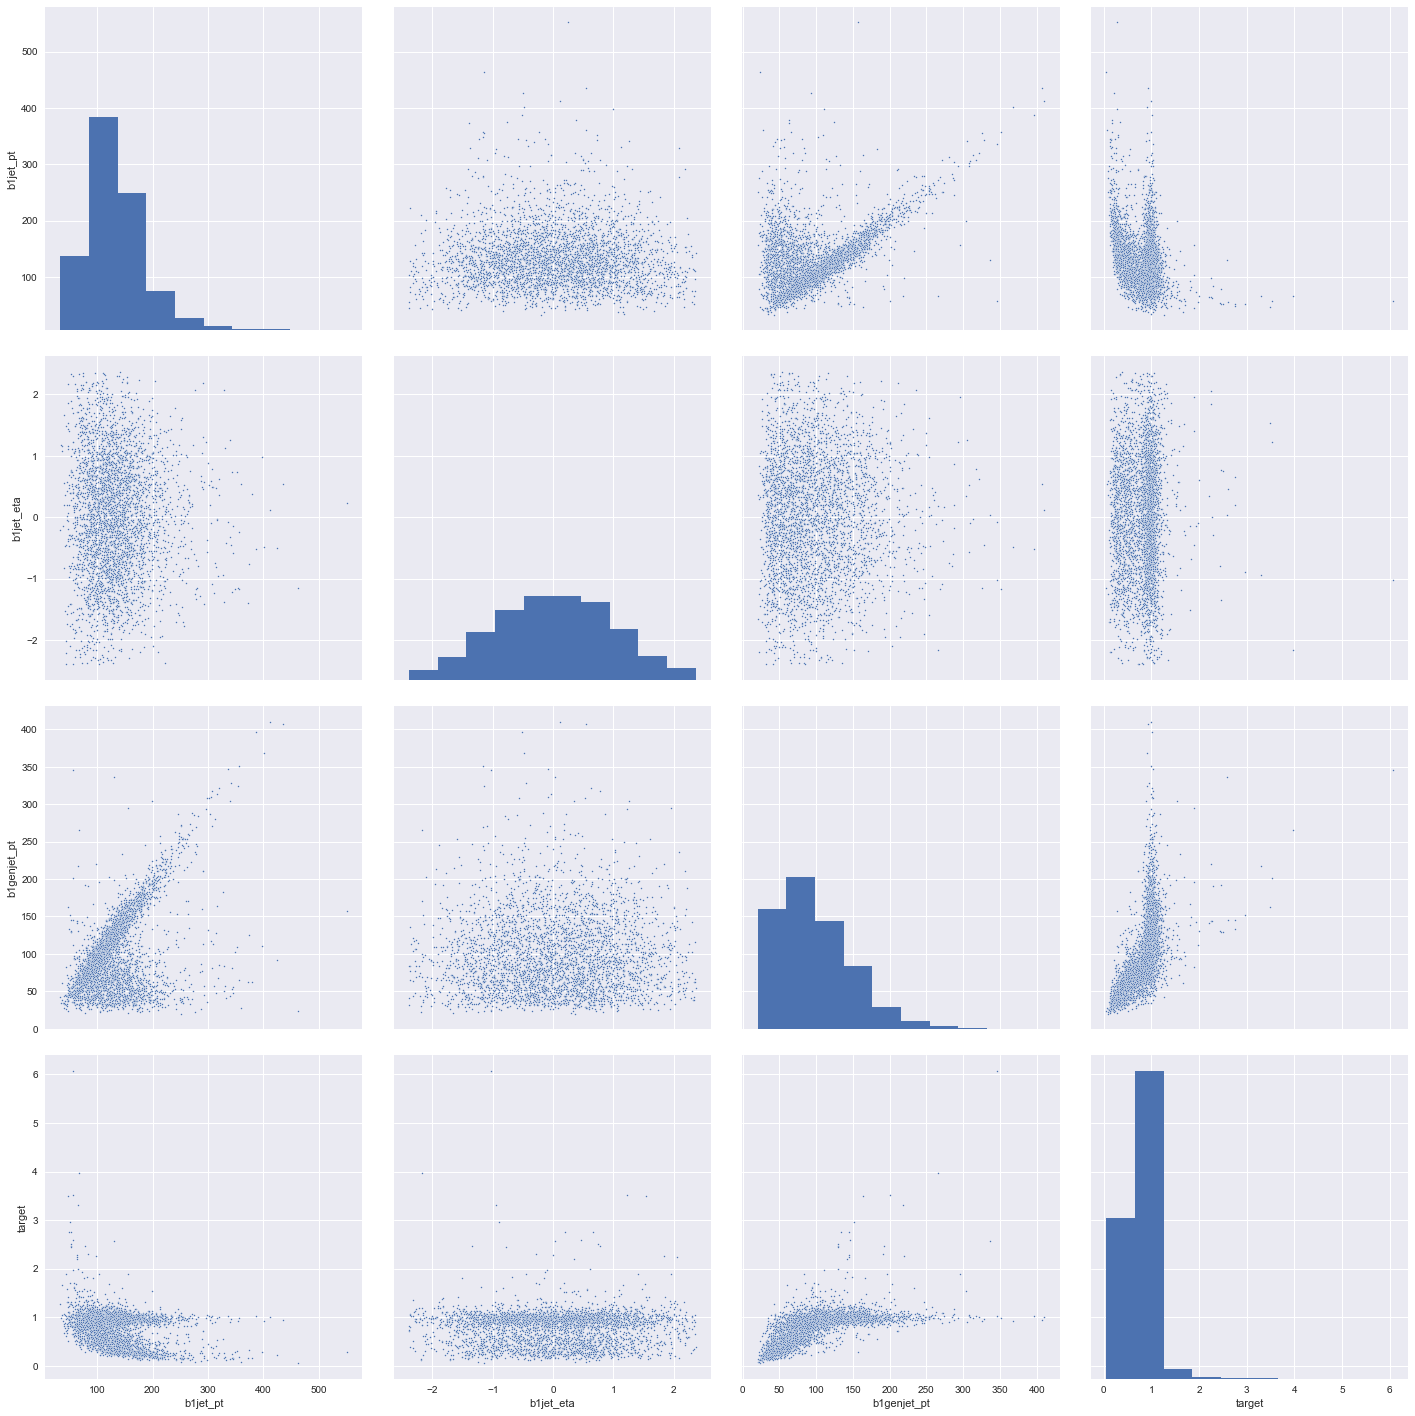

In [38]:
# This takes a while, but it is worth do do it once. It shows the correlations for S and B overimposed.
# More variables you add in var_toPlot, more times it takes.
if MakePlots:
    # Next lines to select the same number of entries
    var_toPlot = ["target","numOfVertices","b1jet_pt","b1jet_eta","b1jet_mt","b1jet_leadTrackPt","b1jet_leptonDeltaR","b1jet_leptonPtRel","b1jet_leptonPt","b1jet_vtxPt","b1jet_vtxMass","b1jet_vtxNtracks","b1jet_neHEF","b1jet_neEmEF","b1jet_vtx3DSig","b1jet_vtx3DVal","b1genjet_pt"]
    if (doSubLead):
        var_toPlot = ["target","numOfVertices","b2jet_pt","b2jet_eta","b2jet_mt","b2jet_leadTrackPt","b2jet_leptonDeltaR","b2jet_leptonPtRel","b2jet_leptonPt","b2jet_vtxPt","b2jet_vtxMass","b2jet_vtxNtracks","b2jet_neHEF","b2jet_neEmEF","b2jet_vtx3DSig","b2jet_vtx3DVal","b2genjet_pt"]
    # You can select the variable to plot in sns.pairplot using an argumnet vars=['var1','var2'...]
    sns_plot = sns.pairplot(LeadJet,palette=["#e74c3c"],plot_kws={"s": 3},size=5)
    sns_plot.savefig(folder + "/Variables_pairplot_LeadingJet.png")

In [39]:
# Regression
def baseline_model():
    model = Sequential()
    model.add(Dense(13, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')) # Linear transformation of the input vector. The first number is output_dim.\n",    
    model.add(Dense(20, activation='relu'))
    #model.add(Dropout(0.1))
#    model.add(Dense(20, activation='sigmoid'))
#    #model.add(Dropout(0.1))
#    model.add(Dense(10,activation='tanh'))
#    #model.add(Dropout(0.1))
#    model.add(Dense(20, activation='sigmoid'))
#    #model.add(Dropout(0.1))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=50, verbose=1)

model_name="tutorial_regression-progress_LeadJet.h5"
if doSubLead: model_name="tutorial_regression-progress_SubLeadJet.h5"

print "Now fitting the Train sample to get our model"
history = estimator.fit(X_train,y_train,              
            callbacks = [
              EarlyStopping(verbose=True, patience=6, monitor='val_loss'),
              ModelCheckpoint('models/'+model_name, monitor='val_loss', verbose=1, save_best_only=True)
            ], validation_split=0.2, validation_data=None, shuffle=True,
            sample_weight=None, initial_epoch=0)

Now fitting the Train sample to get our model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 13)                39        
_________________________________________________________________
dense_8 (Dense)              (None, 20)                280       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 21        
Total params: 340
Trainable params: 340
Non-trainable params: 0
_________________________________________________________________
Train on 2032 samples, validate on 509 samples
Epoch 1/10
2032/2032 [==============================] - 0s - loss: 0.6325 - val_loss: 0.3922
Epoch 2/10
2032/2032 [==============================] - 0s - loss: 0.2742 - val_loss: 0.1215
Epoch 3/10
2032/2032 [==============================] - 0s - loss: 0.1337 - val_loss: 0.0995
Epoch 4/10
2032/2032 [==============

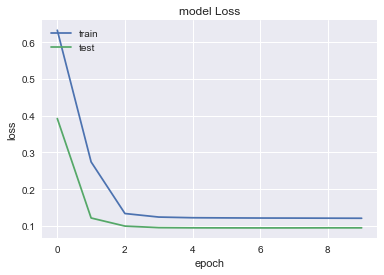

All data in hisotry are:  ['loss', 'val_loss']
Saving weights...
Testing...
  50/1089 [>.............................] - ETA: 0s
score: 0.0933869354653


In [40]:
if debug:
    print "All data in hisotry are: ",history.history.keys()
# Summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(folder + '/Check_loss.pdf')

# Load the best network (by default you return the last one, you if you save every time you have a better one you are fine loading it later)
estimator.model.load_weights('models/'+model_name)
print 'Saving weights...'
model_name="tutorial_regression_LeadJet.h5"
if doSubLead: model_name="tutorial_regression_SubLeadJet.h5"
estimator.model.save_weights('models/'+model_name, overwrite=True)
json_string = estimator.model.to_json()
model_name="tutorial_regression_LeadJet.json"
if doSubLead: model_name="tutorial_regression_SubLeadJet.json"
open('models/'+model_name, 'w').write(json_string)
print 'Testing...'
# Get a prediction on the test
y_hat = estimator.predict(X_test)
# Get the score
score = estimator.score(X_test, y_test)
print; print "score:", score

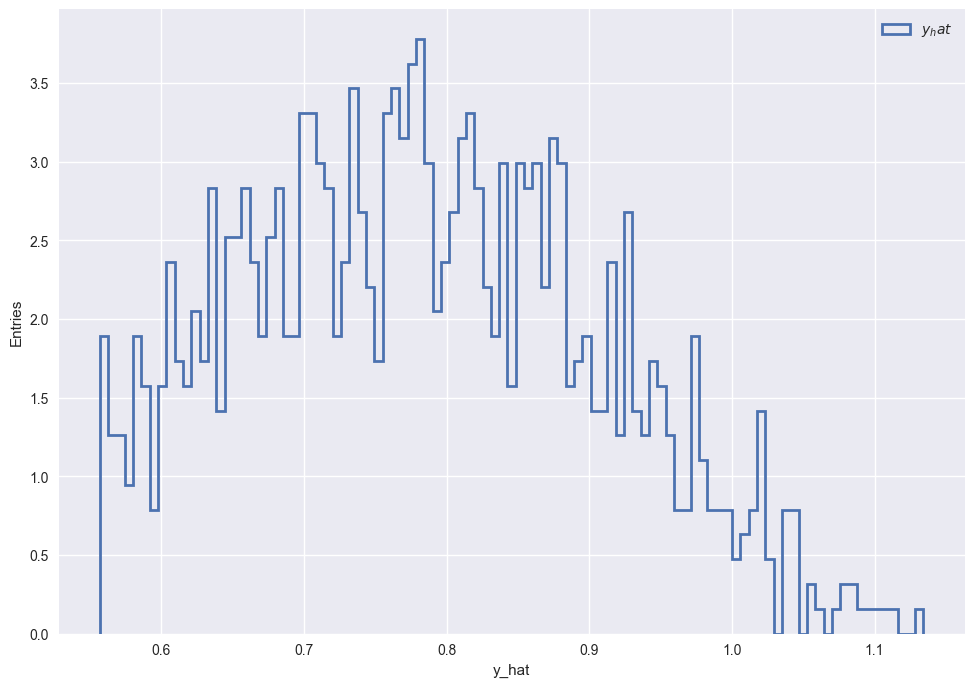

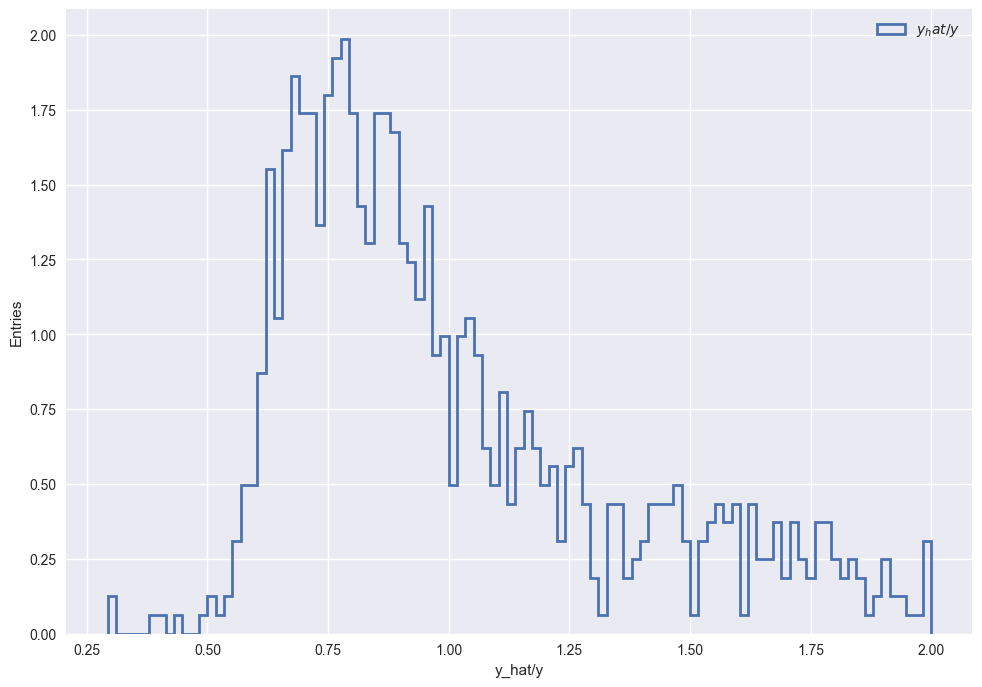

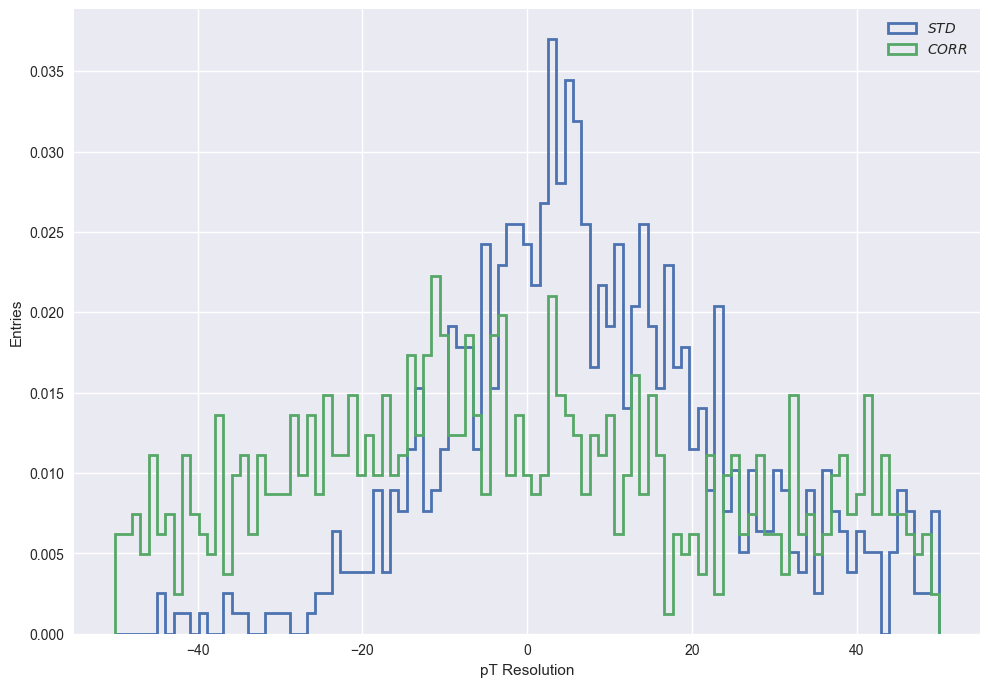

('Saving:', 'Plots_Regression//Regression_y_hat.pdf')
('Saving:', 'Plots_Regression//Regression_y_hat_OverY.pdf')


In [41]:
# Plot the test target and the estimated one
%matplotlib inline
if MakePlots:
    # Estimatd target
    matplotlib.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
    bins = np.linspace(my_max(min(y_hat),0.), max(y_hat), 100)
    _ = plt.hist(y_hat,  bins=bins, histtype='step', normed=True, label=r'$y_hat$', linewidth=2)
    plt.xlabel("y_hat")
    plt.ylabel('Entries')
    plt.legend(loc='best')
    print('Saving:',folder + '/Regression_y_hat.pdf')
    plt.savefig(folder + '/Regression_y_hat.pdf')
    # Estimatd target/ True target
    matplotlib.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
    bins = np.linspace(my_max(min(y_hat/y_test),0.), 2, 100)
    _ = plt.hist(y_hat/y_test,  bins=bins, histtype='step', normed=True, label=r'$y_hat/y$', linewidth=2)
    plt.xlabel("y_hat/y")
    plt.ylabel('Entries')
    plt.legend(loc='best')
    print('Saving:',folder + '/Regression_y_hat_OverY.pdf')
    plt.savefig(folder + '/Regression_y_hat_OverY.pdf')
    # Pt Resolution Before After (first I have to find the index in X_test that corresponf to the Jet and Genjet pT)
    if not doSubLead:
        JetPt    = LeadJet["b1jet_pt"]
        GenJetPt = LeadJet["b1genjet_pt"]
    else:
        JetPt    = LeadJet["b2jet_pt"]
        GenJetPt = LeadJet["b2genjet_pt"]
    test_JetPt    = JetPt[ix_test]
    test_GenJetPt = GenJetPt[ix_test]
    #test_JetPt    = JetPt[ix_train]
    #test_GenJetPt = GenJetPt[ix_train]
    #y_hat = estimator.predict(X_train)
    
    Variable       = (test_JetPt-test_GenJetPt)
    Variable_corr  = (test_JetPt*y_hat-test_GenJetPt) 
    Variable_ideal = (test_JetPt*y_test-test_GenJetPt)
    #Variable_ideal = (test_JetPt*y_train-test_GenJetPt)
    matplotlib.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
    bins = np.linspace(-50, 50, 100)
    _ = plt.hist(Variable,  bins=bins, histtype='step', normed=True, label=r'$STD$', linewidth=2)
    _ = plt.hist(Variable_corr,  bins=bins, histtype='step', normed=True, label=r'$CORR$', linewidth=2)
    #You chan check if this below is a single Bin in 0
    #_ = plt.hist(Variable_ideal,  bins=bins, histtype='step', normed=True, label=r'$IDEAL$', linewidth=2)
    plt.xlabel("pT Resolution")
    plt.ylabel('Entries')
    plt.legend(loc='best')
    plt.savefig(folder + '/Regression_PtRes.pdf')

#kfold = KFold(n_splits=10, random_state=seed)
#results = cross_val_score(estimator, X, Y, cv=kfold)
#print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))